To develop accurate and robust predictive models for estimating taxi trip durations, which can have real-world applications in the taxi and transportation industry.

# Problem Statement:

Given a dataset of taxi trip records, including information such as pickup date and time, geographical coordinates (longitude and latitude) of the pickup and dropoff locations, the number of passengers, and other attributes, the task is to develop a regression model that can accurately predict the duration of a taxi trip in seconds. This model should be trained on a labeled dataset containing historical trip records (the training set) and then applied to a separate dataset of unlabeled trip records (the testing set) to estimate the trip durations.

## Dataset Description

The competition dataset is based on the 2016 NYC Yellow Cab trip record data made available in Big Query on Google Cloud Platform. The data was originally published by the NYC Taxi and Limousine Commission (TLC). The data was sampled and cleaned for the purposes of this playground competition. Based on individual trip attributes, participants should predict the duration of each trip in the test set.

File descriptions
train.csv - the training set (contains 1458644 trip records)
test.csv - the testing set (contains 625134 trip records)
sample_submission.csv - a sample submission file in the correct format


## Data fields

id - a unique identifier for each trip

vendor_id - a code indicating the provider associated with the trip record

pickup_datetime - date and time when the meter was engaged

dropoff_datetime - date and time when the meter was disengaged

passenger_count - the number of passengers in the vehicle (driver entered value)

pickup_longitude - the longitude where the meter was engaged

pickup_latitude - the latitude where the meter was engaged

dropoff_longitude - the longitude where the meter was disengaged

dropoff_latitude - the latitude where the meter was disengaged

store_and_fwd_flag - This flag indicates whether the trip record was held in vehicle memory before sending to the vendor because the vehicle did not have a connection to the server - Y=store and forward; N=not a store and forward trip

trip_duration - duration of the trip in seconds

Disclaimer: The decision was made to not remove dropoff coordinates from the dataset order to provide an expanded set of variables to use in Kernels.

# Data Loading

In [1]:
# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#!unzip '/content/drive/MyDrive/kaggle dataset/NYC Trip Yellow Comp Dataset/nyc-taxi-trip-duration.zip' -d '/content/drive/MyDrive/kaggle dataset/NYC Trip Yellow Comp Dataset'

In [3]:
pwd

'/content'

In [4]:
#%cd '/content/drive/MyDrive/kaggle dataset/NYC Trip Yellow Comp Dataset'

In [5]:
import os

In [6]:
# Specify the directory path to list
# directory_path = '/content/drive/MyDrive/kaggle dataset/NYC Trip Yellow Comp Dataset'

# # Get a list of all contents in the specified directory
# contents = os.listdir(directory_path)

# # Print the list of contents
# for item in contents:
#     print(item)

In [7]:
#!unzip '/content/drive/MyDrive/kaggle dataset/NYC Trip Yellow Comp Dataset/train.zip' -d '/content/drive/MyDrive/kaggle dataset/Dataset Unzipped New York City Taxi Trip Duration'

In [8]:
#!unzip '/content/drive/MyDrive/kaggle dataset/NYC Trip Yellow Comp Dataset/test.zip' -d '/content/drive/MyDrive/kaggle dataset/Dataset Unzipped New York City Taxi Trip Duration'

In [9]:
# Specify the directory path you want to list
directory_path = '/content/drive/MyDrive/kaggle dataset/Dataset Unzipped New York City Taxi Trip Duration'

# Get a list of all contents in the specified directory
contents = os.listdir(directory_path)

# Print the list of contents
for item in contents:
    print(item)

train.csv
test.csv
lgbm_model.pkl


In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sea

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from lightgbm import LGBMRegressor
from sklearn.model_selection import GridSearchCV
import joblib

In [11]:
%cd '/content/drive/MyDrive/kaggle dataset/Dataset Unzipped New York City Taxi Trip Duration'

/content/drive/MyDrive/kaggle dataset/Dataset Unzipped New York City Taxi Trip Duration


In [12]:
train_df = pd.read_csv('/content/drive/MyDrive/kaggle dataset/Dataset Unzipped New York City Taxi Trip Duration/train.csv')
test_df = pd.read_csv('/content/drive/MyDrive/kaggle dataset/Dataset Unzipped New York City Taxi Trip Duration/test.csv')

# EDA : Exploratory Data Analysis

In [13]:
print(train_df.shape)
print(test_df.shape)

(1458644, 11)
(625134, 9)


In [14]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   id                  1458644 non-null  object 
 1   vendor_id           1458644 non-null  int64  
 2   pickup_datetime     1458644 non-null  object 
 3   dropoff_datetime    1458644 non-null  object 
 4   passenger_count     1458644 non-null  int64  
 5   pickup_longitude    1458644 non-null  float64
 6   pickup_latitude     1458644 non-null  float64
 7   dropoff_longitude   1458644 non-null  float64
 8   dropoff_latitude    1458644 non-null  float64
 9   store_and_fwd_flag  1458644 non-null  object 
 10  trip_duration       1458644 non-null  int64  
dtypes: float64(4), int64(3), object(4)
memory usage: 122.4+ MB


In [15]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 625134 entries, 0 to 625133
Data columns (total 9 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   id                  625134 non-null  object 
 1   vendor_id           625134 non-null  int64  
 2   pickup_datetime     625134 non-null  object 
 3   passenger_count     625134 non-null  int64  
 4   pickup_longitude    625134 non-null  float64
 5   pickup_latitude     625134 non-null  float64
 6   dropoff_longitude   625134 non-null  float64
 7   dropoff_latitude    625134 non-null  float64
 8   store_and_fwd_flag  625134 non-null  object 
dtypes: float64(4), int64(2), object(3)
memory usage: 42.9+ MB


In [16]:
train_col = train_df.columns
print(train_col)

Index(['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'trip_duration'],
      dtype='object')


In [17]:
test_col = test_df.columns
print(test_col)

Index(['id', 'vendor_id', 'pickup_datetime', 'passenger_count',
       'pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
       'dropoff_latitude', 'store_and_fwd_flag'],
      dtype='object')


In [18]:
train_df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


In [19]:
test_df.head()

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag
0,id3004672,1,2016-06-30 23:59:58,1,-73.988129,40.732029,-73.990173,40.756680,N
1,id3505355,1,2016-06-30 23:59:53,1,-73.964203,40.679993,-73.959808,40.655403,N
2,id1217141,1,2016-06-30 23:59:47,1,-73.997437,40.737583,-73.986160,40.729523,N
3,id2150126,2,2016-06-30 23:59:41,1,-73.956070,40.771900,-73.986427,40.730469,N
4,id1598245,1,2016-06-30 23:59:33,1,-73.970215,40.761475,-73.961510,40.755890,N


# Data Wrangling

In [20]:
train_df.duplicated().sum()

0

In [21]:
test_df.duplicated().sum()

0

In [22]:
train_df.isna().sum()

id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64

In [23]:
test_df.isna().sum()

id                    0
vendor_id             0
pickup_datetime       0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
dtype: int64

Wow !! there are no missing values in the dataframes. ❗

# Data Analysis continued..

In [24]:
# Summary statistics
print("\nSummary Statistics:")
print(train_df.describe())


Summary Statistics:
          vendor_id  passenger_count  pickup_longitude  pickup_latitude  \
count  1.458644e+06     1.458644e+06      1.458644e+06     1.458644e+06   
mean   1.534950e+00     1.664530e+00     -7.397349e+01     4.075092e+01   
std    4.987772e-01     1.314242e+00      7.090186e-02     3.288119e-02   
min    1.000000e+00     0.000000e+00     -1.219333e+02     3.435970e+01   
25%    1.000000e+00     1.000000e+00     -7.399187e+01     4.073735e+01   
50%    2.000000e+00     1.000000e+00     -7.398174e+01     4.075410e+01   
75%    2.000000e+00     2.000000e+00     -7.396733e+01     4.076836e+01   
max    2.000000e+00     9.000000e+00     -6.133553e+01     5.188108e+01   

       dropoff_longitude  dropoff_latitude  trip_duration  
count       1.458644e+06      1.458644e+06   1.458644e+06  
mean       -7.397342e+01      4.075180e+01   9.594923e+02  
std         7.064327e-02      3.589056e-02   5.237432e+03  
min        -1.219333e+02      3.218114e+01   1.000000e+00  
25%

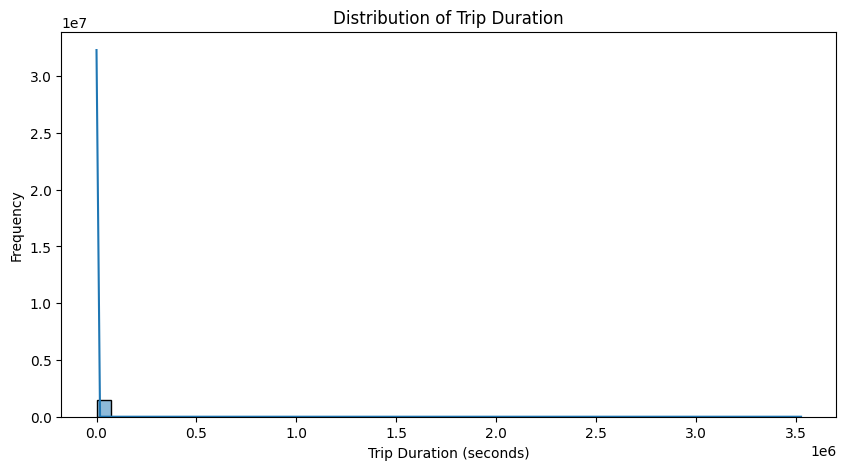

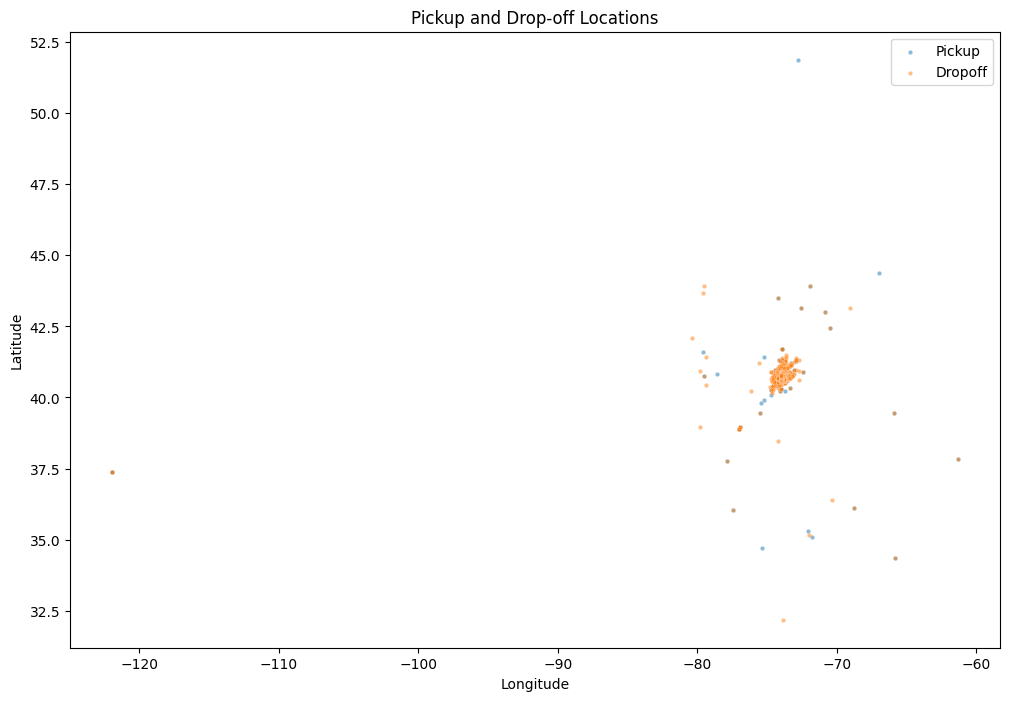

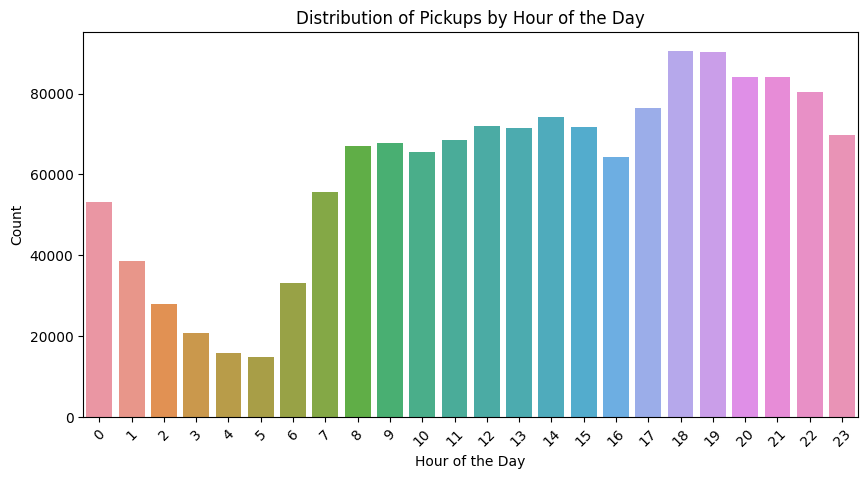

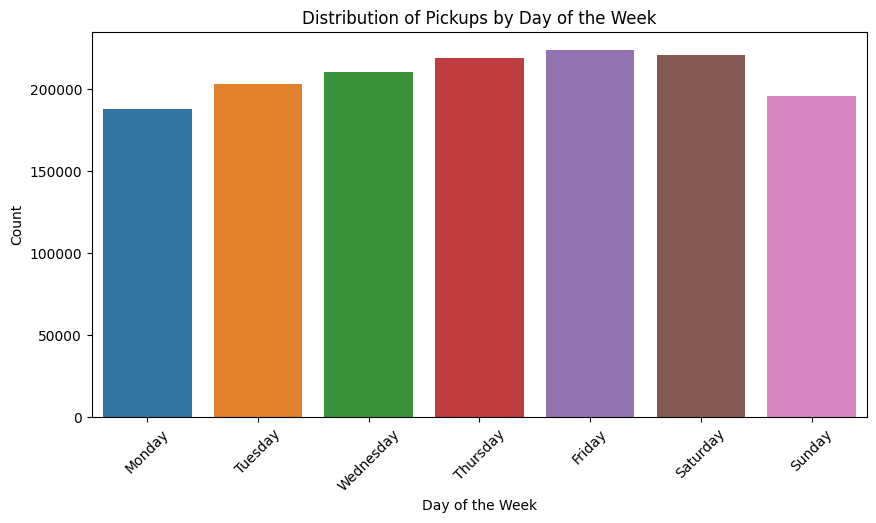

In [25]:
# Distribution of trip duration
plt.figure(figsize=(10, 5))
sea.histplot(train_df['trip_duration'], kde=True, bins=50)
plt.title('Distribution of Trip Duration')
plt.xlabel('Trip Duration (seconds)')
plt.ylabel('Frequency')
plt.show()

# Spatial Analysis - Pickup and Drop-off Locations
plt.figure(figsize=(12, 8))
sea.scatterplot(x='pickup_longitude', y='pickup_latitude', data = train_df, alpha=0.5, label='Pickup', s=10)
sea.scatterplot(x='dropoff_longitude', y='dropoff_latitude', data = train_df, alpha=0.5, label='Dropoff', s=10)
plt.title('Pickup and Drop-off Locations')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.show()

# Temporal Analysis - Pickup Date and Time
train_df['pickup_datetime'] = pd.to_datetime(train_df['pickup_datetime'])
train_df['pickup_date'] = train_df['pickup_datetime'].dt.date
train_df['pickup_hour'] = train_df['pickup_datetime'].dt.hour
train_df['pickup_day'] = train_df['pickup_datetime'].dt.day_name()

# Distribution of pickups by hour of the day
plt.figure(figsize=(10, 5))
sea.countplot(data = train_df, x='pickup_hour')
plt.title('Distribution of Pickups by Hour of the Day')
plt.xlabel('Hour of the Day')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

# Distribution of pickups by day of the week
plt.figure(figsize=(10, 5))
sea.countplot(data = train_df, x='pickup_day', order=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"])
plt.title('Distribution of Pickups by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()


## Scatter Plots

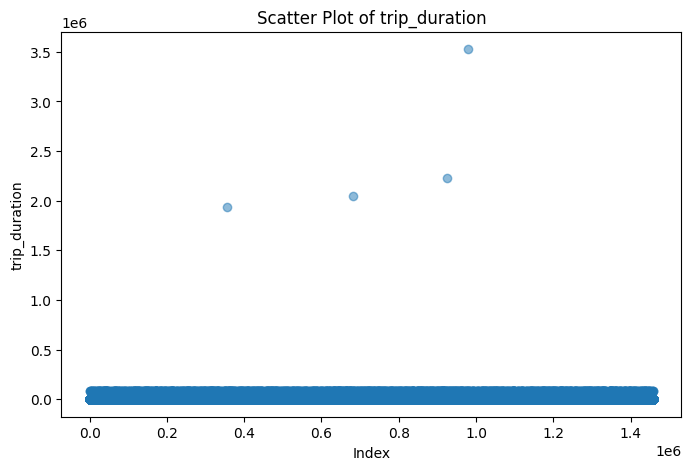

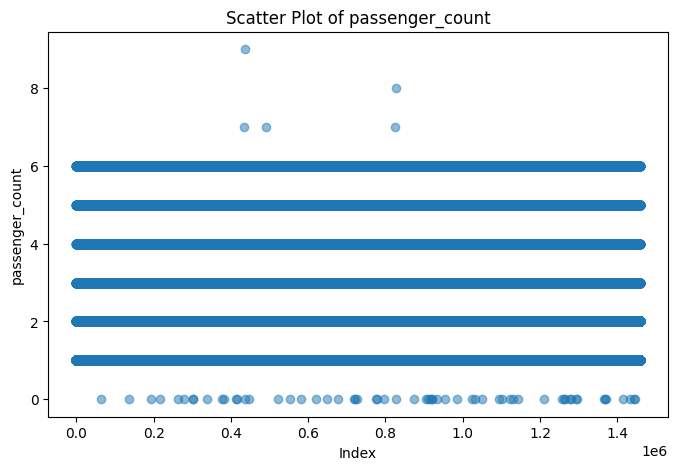

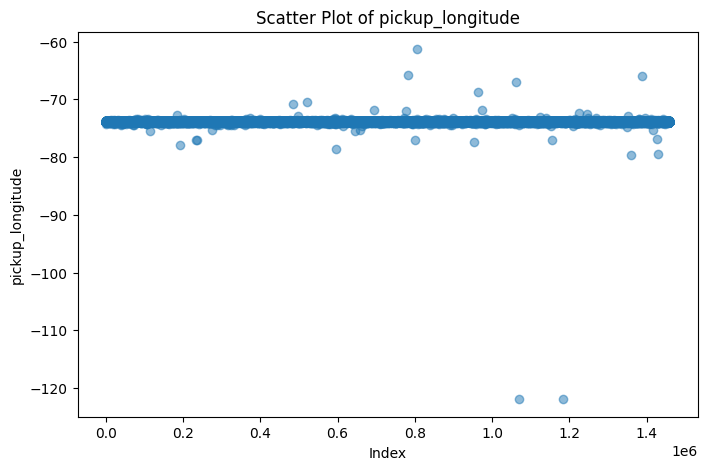

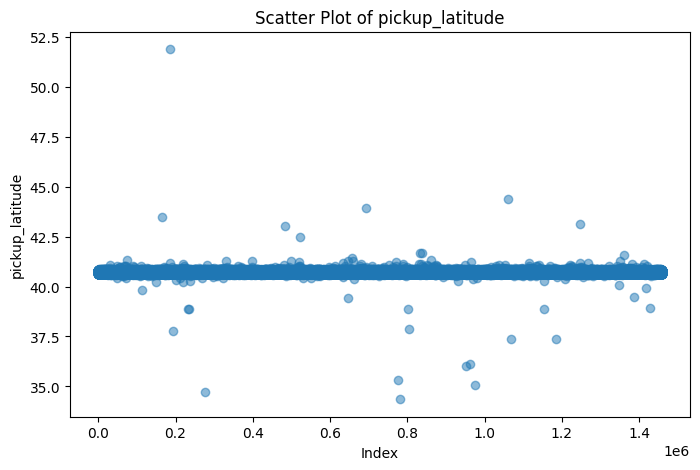

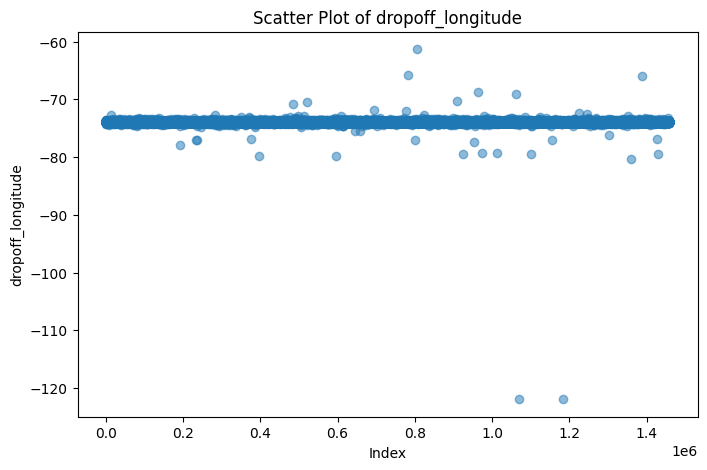

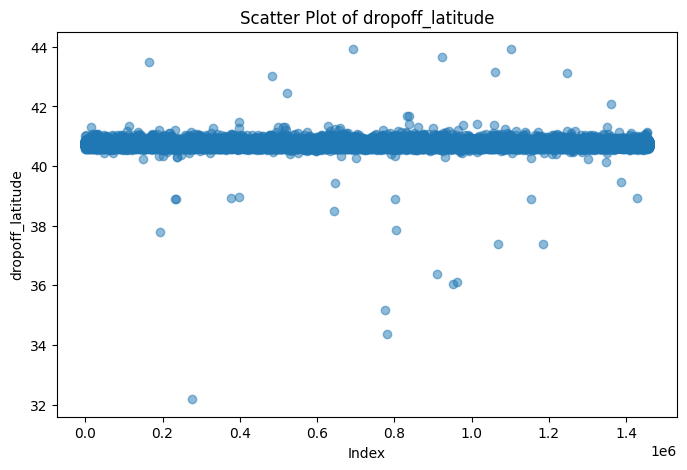

In [26]:
# Specify the columns you want to create scatter plots for
columns_to_plot = ['trip_duration', 'passenger_count', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude']

# Create scatter plots for the specified columns
for column in columns_to_plot:
    plt.figure(figsize=(8, 5))
    plt.scatter(train_df.index, train_df[column], alpha=0.5)
    plt.title(f'Scatter Plot of {column}')
    plt.xlabel('Index')
    plt.ylabel(column)
    plt.show()


## Insights from Data Analysis

Towards the end of the week (i.e., Thursday, Friday and Saturday), trip count
is huge and is more than 2L.

Trips are the highest during 5PM and 6PM and generally, trips are more from 5PM to 10 PM.

Trips are least from 12 AM to 5AM.

Generally trips are more from 8AM to 11 PM.

# Feature Engineering

Extract relevant features from the data that can affect trip duration, such as:


1.   Distance between start and end points.
2.   Day of the week, time of day.


In [27]:
train_df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_date,pickup_hour,pickup_day
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,2016-03-14,17,Monday
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,2016-06-12,0,Sunday
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,2016-01-19,11,Tuesday
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,2016-04-06,19,Wednesday
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,2016-03-26,13,Saturday


In [28]:
# train_df['pickup_datetime'] = pd.to_datetime(train_df['pickup_datetime'])
# train_df['pickup_date'] = train_df['pickup_datetime'].dt.date
# train_df['pickup_hour'] = train_df['pickup_datetime'].dt.hour
# train_df['pickup_day'] = train_df['pickup_datetime'].dt.day_name()


In [29]:
train_df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_date,pickup_hour,pickup_day
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,2016-03-14,17,Monday
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,2016-06-12,0,Sunday
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,2016-01-19,11,Tuesday
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,2016-04-06,19,Wednesday
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,2016-03-26,13,Saturday


In [30]:
test_df['pickup_datetime'] = pd.to_datetime(test_df['pickup_datetime'])
test_df['pickup_date'] = test_df['pickup_datetime'].dt.date
test_df['pickup_hour'] = test_df['pickup_datetime'].dt.hour
test_df['pickup_day'] = test_df['pickup_datetime'].dt.day_name()

In [31]:
test_df.head()

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,pickup_date,pickup_hour,pickup_day
0,id3004672,1,2016-06-30 23:59:58,1,-73.988129,40.732029,-73.990173,40.756680,N,2016-06-30,23,Thursday
1,id3505355,1,2016-06-30 23:59:53,1,-73.964203,40.679993,-73.959808,40.655403,N,2016-06-30,23,Thursday
2,id1217141,1,2016-06-30 23:59:47,1,-73.997437,40.737583,-73.986160,40.729523,N,2016-06-30,23,Thursday
3,id2150126,2,2016-06-30 23:59:41,1,-73.956070,40.771900,-73.986427,40.730469,N,2016-06-30,23,Thursday
4,id1598245,1,2016-06-30 23:59:33,1,-73.970215,40.761475,-73.961510,40.755890,N,2016-06-30,23,Thursday


The 'id' column seems to be a redundant info in both the data frames. So as the "store_and_fwd_flag" column is not relevant to this problem. So removing them.

In [32]:
train_c = train_df.drop(columns = ['id','store_and_fwd_flag'])
test_c = test_df.drop(columns = ['id','store_and_fwd_flag'])
train_c.shape

(1458644, 12)

In [33]:
test_c.shape

(625134, 10)

In [34]:
test_c.head()

,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,pickup_date,pickup_hour,pickup_day
0,1,2016-06-30 23:59:58,1,-73.988129,40.732029,-73.990173,40.756680,2016-06-30,23,Thursday
1,1,2016-06-30 23:59:53,1,-73.964203,40.679993,-73.959808,40.655403,2016-06-30,23,Thursday
2,1,2016-06-30 23:59:47,1,-73.997437,40.737583,-73.986160,40.729523,2016-06-30,23,Thursday
3,2,2016-06-30 23:59:41,1,-73.956070,40.771900,-73.986427,40.730469,2016-06-30,23,Thursday
4,1,2016-06-30 23:59:33,1,-73.970215,40.761475,-73.961510,40.755890,2016-06-30,23,Thursday


In [35]:
train_c.head()

,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,pickup_date,pickup_hour,pickup_day
0,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,455,2016-03-14,17,Monday
1,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,663,2016-06-12,0,Sunday
2,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,2124,2016-01-19,11,Tuesday
3,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,429,2016-04-06,19,Wednesday
4,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,435,2016-03-26,13,Saturday


## Distance between start and end points

In [36]:
def haversine(lat1, lon1, lat2, lon2):
    """
    Calculate the Haversine distance between two sets of coordinates (latitude and longitude).

    The haversine function  calculates the distance between two sets of coordinates.
    It can then be applied to each row in your DataFrame to calculate the distance between the pickup and drop-off points
    and adds the result to a new 'distance' column in the DataFrame.
    """
    # Radius of the Earth in kilometers
    R = 6371.0

    # Convert latitude and longitude from degrees to radians
    lat1 = np.radians(lat1)
    lon1 = np.radians(lon1)
    lat2 = np.radians(lat2)
    lon2 = np.radians(lon2)

    # Haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

    distance = R * c
    return distance

In [37]:
# Apply the haversine function to calculate the distance for each row
train_c['distance'] = train_c.apply(lambda row: haversine(row['pickup_latitude'], row['pickup_longitude'], row['dropoff_latitude'], row['dropoff_longitude']), axis=1)
test_c['distance'] = test_c.apply(lambda row: haversine(row['pickup_latitude'], row['pickup_longitude'], row['dropoff_latitude'], row['dropoff_longitude']), axis=1)


In [38]:
train_c.head()

,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,pickup_date,pickup_hour,pickup_day,distance
0,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,455,2016-03-14,17,Monday,1.498521
1,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,663,2016-06-12,0,Sunday,1.805507
2,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,2124,2016-01-19,11,Tuesday,6.385098
3,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,429,2016-04-06,19,Wednesday,1.485498
4,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,435,2016-03-26,13,Saturday,1.188588


The newly added column "distance" is in Kilometers.

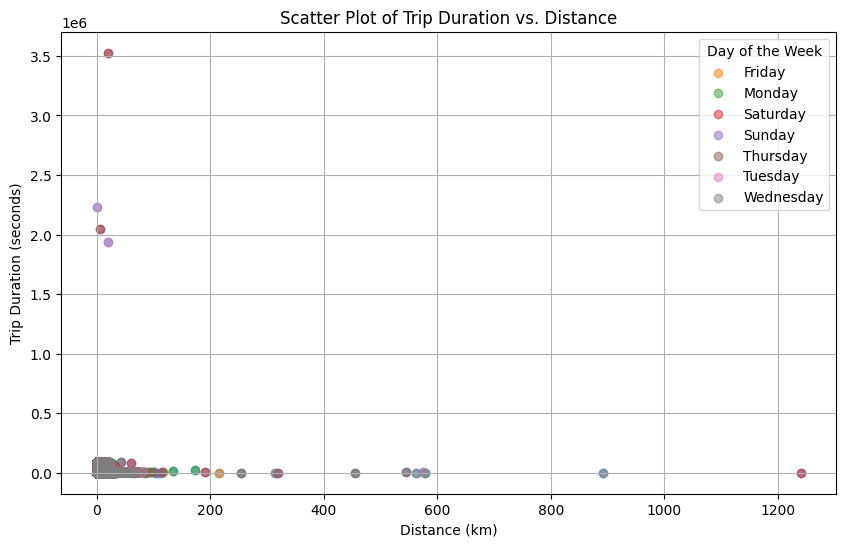

In [39]:
# Create a scatter plot with distance vs. trip duration
plt.figure(figsize=(10, 6))
plt.scatter(train_c['distance'], train_c['trip_duration'], alpha=0.5)

# Customize the plot with labels, title, and legend
plt.xlabel('Distance (km)')
plt.ylabel('Trip Duration (seconds)')
plt.title('Scatter Plot of Trip Duration vs. Distance')

# You can use different colors/markers to represent factors like day of the week, time of day, or vendor type
# For example, if you have a 'day_of_week' column, you can color the points based on the day of the week
# For different markers, you can use the 'vendor_id' column
for day, group in train_c.groupby('pickup_day'):
    plt.scatter(group['distance'], group['trip_duration'], label=day, alpha=0.5)

# Add a legend to differentiate the points by day of the week
plt.legend(title='Day of the Week')

# Show the plot
plt.grid(True)
plt.show()


Adding a regression line to this scatter plot to visualize the overall trend between distance and trip duration.

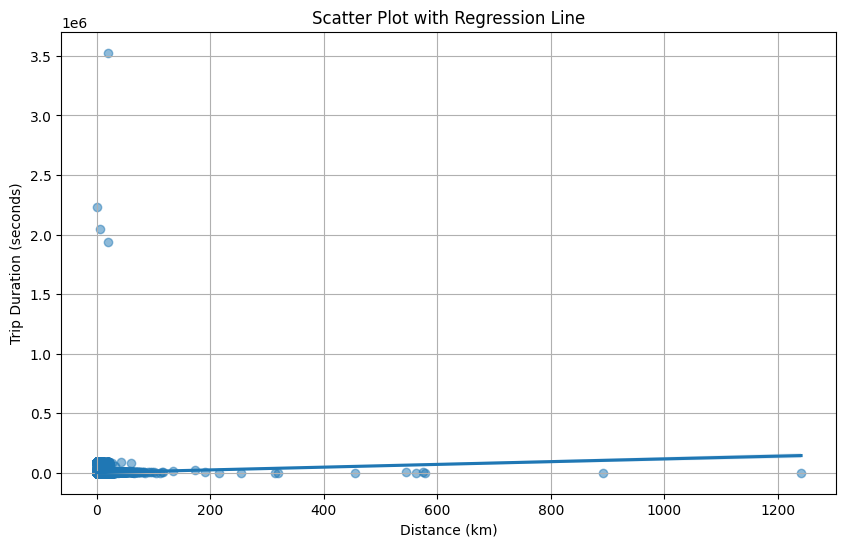

In [40]:
# Create a scatter plot with a regression line (takes 4 minutes to plot)
plt.figure(figsize=(10, 6))
sea.regplot(x='distance', y='trip_duration', data=train_c, scatter_kws={'alpha':0.5})

# Customize the plot with labels and title
plt.xlabel('Distance (km)')
plt.ylabel('Trip Duration (seconds)')
plt.title('Scatter Plot with Regression Line')

# Show the plot
plt.grid(True)
plt.show()


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


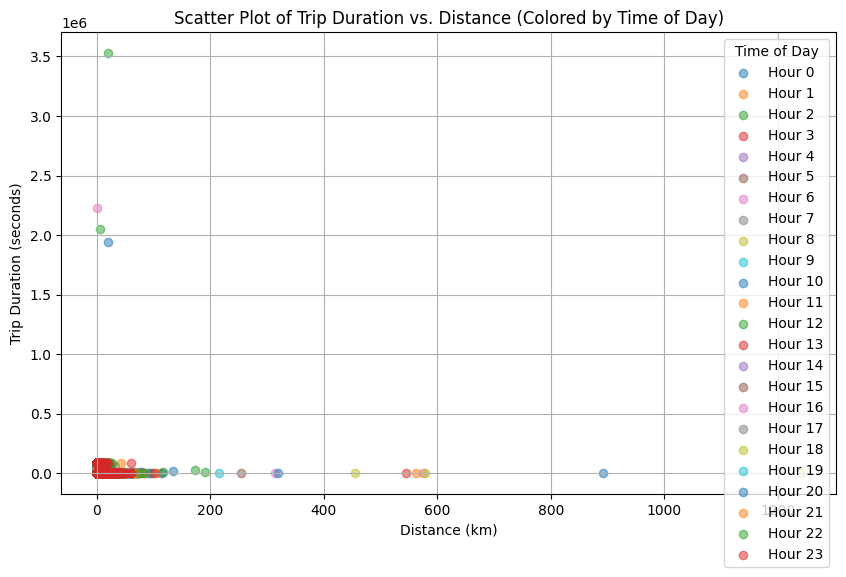

In [41]:
# Create a scatter plot with distance vs. trip duration, using time of day for color
plt.figure(figsize=(10, 6))
for hour, group in train_c.groupby('pickup_hour'):
    plt.scatter(group['distance'], group['trip_duration'], label=f'Hour {hour}', alpha=0.5)

# Customize the plot with labels and title
plt.xlabel('Distance (km)')
plt.ylabel('Trip Duration (seconds)')
plt.title('Scatter Plot of Trip Duration vs. Distance (Colored by Time of Day)')

# Add a legend to differentiate the points by time of day
plt.legend(title='Time of Day')

# Show the plot
plt.grid(True)
plt.show()


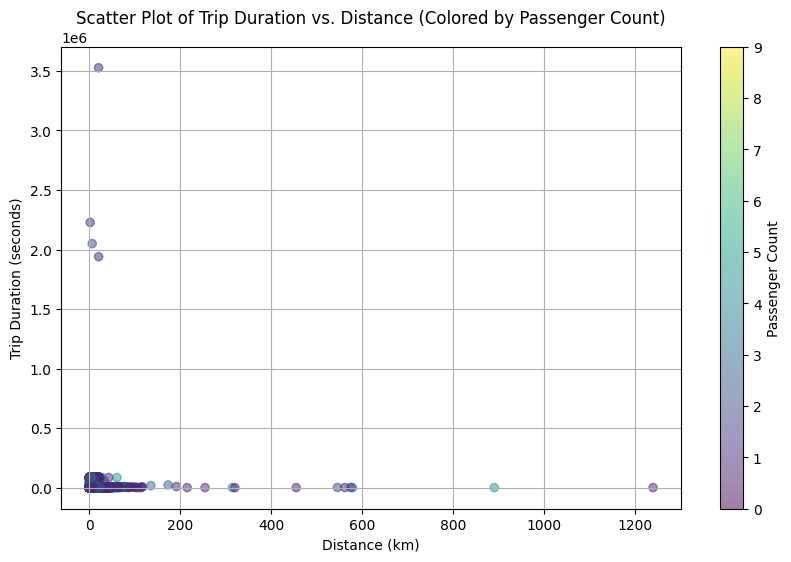

In [42]:
# Create a scatter plot with distance vs. trip duration, using passenger count for color
plt.figure(figsize=(10, 6))
scatter = plt.scatter(train_c['distance'], train_c['trip_duration'], c=train_c['passenger_count'], cmap='viridis', alpha=0.5)
# Customize the plot with labels and title
plt.xlabel('Distance (km)')
plt.ylabel('Trip Duration (seconds)')
plt.title('Scatter Plot of Trip Duration vs. Distance (Colored by Passenger Count)')

# Add a colorbar to represent passenger count
cbar = plt.colorbar(scatter)
cbar.set_label('Passenger Count')
# Show the plot
plt.grid(True)
plt.show()


##  Checking Outliers and treating them

## 1. Remove rows where "passenger_count" is greater than 6 or equal to 0

In [43]:
unique_passenger_counts = train_c['passenger_count'].unique()
print("Unique Passenger Counts:", unique_passenger_counts)

Unique Passenger Counts: [1 6 4 2 3 5 0 7 9 8]


In [44]:
# Remove rows where "passenger_count" is greater than 6 or equal to 0
train_c_outliers = train_c[(train_c['passenger_count'] <= 6) & (train_c['passenger_count'] > 0)]
unique_passenger_counts = train_c_outliers['passenger_count'].unique()
print("Unique Passenger Counts:", unique_passenger_counts)

Unique Passenger Counts: [1 6 4 2 3 5]


In [45]:
train_c_outliers.shape

(1458579, 13)

In [46]:
train_c.shape

(1458644, 13)

# 2. Remove outliers in the distance column

In [47]:
max(train_c_outliers['distance'])

1240.9086766508526

In [48]:
min(train_c_outliers['distance'])

0.0

Also, from the scatter plot above, we understand that distance above 600km are rare. So removing them.

In [49]:
# Filter and print values in the 'distance' column that are above 600
above_600_values = train_c_outliers[train_c_outliers['distance'] > 600]['distance']
print(above_600_values)


184925    1240.908677
974378     891.214103
Name: distance, dtype: float64


In [50]:
below_100m_values = train_c_outliers[train_c_outliers['distance'] < 0.1]['distance']
print(below_100m_values)

246        0.000000
251        0.052661
291        0.000000
323        0.003927
337        0.045892
             ...   
1458044    0.000848
1458291    0.012962
1458371    0.054804
1458544    0.011717
1458602    0.013334
Name: distance, Length: 13270, dtype: float64


In [51]:
# Remove rows with 'distance' greater than 600
train_c_outliers= train_c_outliers[train_c_outliers['distance'] <= 600]
train_c_outliers.shape

(1458577, 13)

In [52]:
# Remove rows with 'distance' lesser than 100m (0.1 kilometers)
train_c_outliers = train_c_outliers[train_c_outliers['distance'] >= 0.1]
train_c_outliers.shape

(1445307, 13)

# 3.  Remove outliers in the trip_duration column

In [53]:
unique_trip_duration = train_c_outliers['trip_duration'].unique()
print("Unique Trip duration:", unique_trip_duration )

Unique Trip duration: [  455   663  2124 ... 86200 72504  6124]


In [54]:
max(train_c_outliers['trip_duration'])

3526282

In [56]:
min(train_c_outliers['trip_duration'])

1

In [57]:
# Calculate the mean and standard deviation of the 'trip_duration' column
mean_trip_duration = train_c_outliers['trip_duration'].mean()
std_dev_trip_duration = train_c_outliers['trip_duration'].std()

# Calculate the Z-scores for each data point
train_c_outliers['trip_duration_z_score'] = (train_c_outliers['trip_duration'] - mean_trip_duration) / std_dev_trip_duration

# Define the Z-score range for "normal" data points
z_score_lower_bound = -3  # Lower bound for Z-score
z_score_upper_bound = 3   # Upper bound for Z-score

# Filter data to remove data points outside the Z-score range
train_c_no_outliers = train_c_outliers[(train_c_outliers['trip_duration_z_score'] >= z_score_lower_bound) & (train_c_outliers['trip_duration_z_score'] <= z_score_upper_bound)]

# Drop the Z-score column, if not needed
train_c_no_outliers.drop(columns=['trip_duration_z_score'], inplace=True)

<ipython-input-57-7a863dda399d>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_c_no_outliers.drop(columns=['trip_duration_z_score'], inplace=True)


In [58]:
max(train_c_outliers['trip_duration'])

3526282

In [59]:
max(train_c_no_outliers['trip_duration'])

15900

In [60]:
min(train_c_no_outliers['trip_duration'])

1

In [61]:
train_c_no_outliers.shape

(1443256, 13)

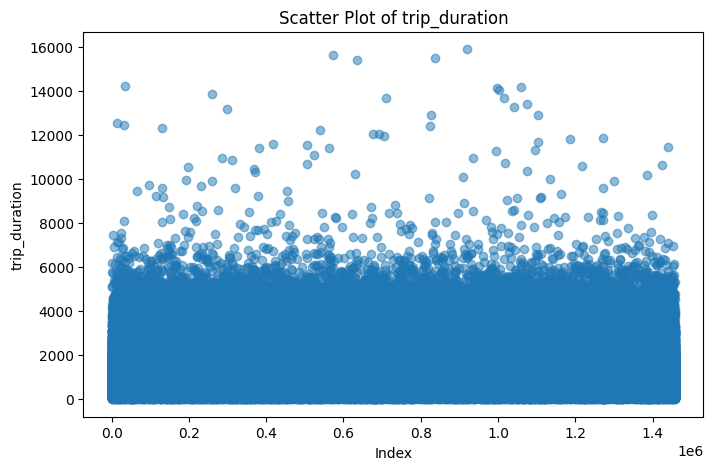

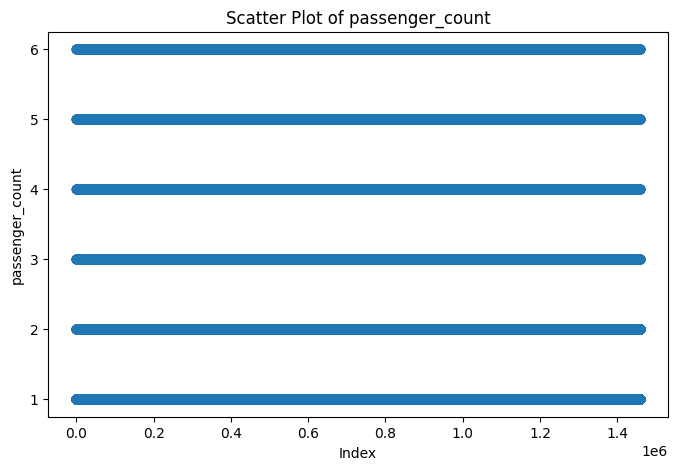

In [62]:
# Specify the columns you want to create scatter plots for
columns_to_plot = ['trip_duration', 'passenger_count'] #, 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude']

# Create scatter plots for the specified columns
for column in columns_to_plot:
    plt.figure(figsize=(8, 5))
    plt.scatter(train_c_no_outliers.index, train_c_no_outliers[column], alpha=0.5)
    plt.title(f'Scatter Plot of {column}')
    plt.xlabel('Index')
    plt.ylabel(column)
    plt.show()

In [63]:
train_c.head()

,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,pickup_date,pickup_hour,pickup_day,distance
0,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,455,2016-03-14,17,Monday,1.498521
1,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,663,2016-06-12,0,Sunday,1.805507
2,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,2124,2016-01-19,11,Tuesday,6.385098
3,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,429,2016-04-06,19,Wednesday,1.485498
4,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,435,2016-03-26,13,Saturday,1.188588


In [64]:
train_c.describe()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,pickup_hour,distance
count,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06
mean,1.534950e+00,1.664530e+00,-7.397349e+01,4.075092e+01,-7.397342e+01,4.075180e+01,9.594923e+02,1.360648e+01,3.440864e+00
std,4.987772e-01,1.314242e+00,7.090186e-02,3.288119e-02,7.064327e-02,3.589056e-02,5.237432e+03,6.399693e+00,4.296538e+00
min,1.000000e+00,0.000000e+00,-1.219333e+02,3.435970e+01,-1.219333e+02,3.218114e+01,1.000000e+00,0.000000e+00,0.000000e+00
25%,1.000000e+00,1.000000e+00,-7.399187e+01,4.073735e+01,-7.399133e+01,4.073588e+01,3.970000e+02,9.000000e+00,1.231837e+00
50%,2.000000e+00,1.000000e+00,-7.398174e+01,4.075410e+01,-7.397975e+01,4.075452e+01,6.620000e+02,1.400000e+01,2.093717e+00
75%,2.000000e+00,2.000000e+00,-7.396733e+01,4.076836e+01,-7.396301e+01,4.076981e+01,1.075000e+03,1.900000e+01,3.875337e+00
max,2.000000e+00,9.000000e+00,-6.133553e+01,5.188108e+01,-6.133553e+01,4.392103e+01,3.526282e+06,2.300000e+01,1.240909e+03


In [65]:
train_col

Index(['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'trip_duration'],
      dtype='object')

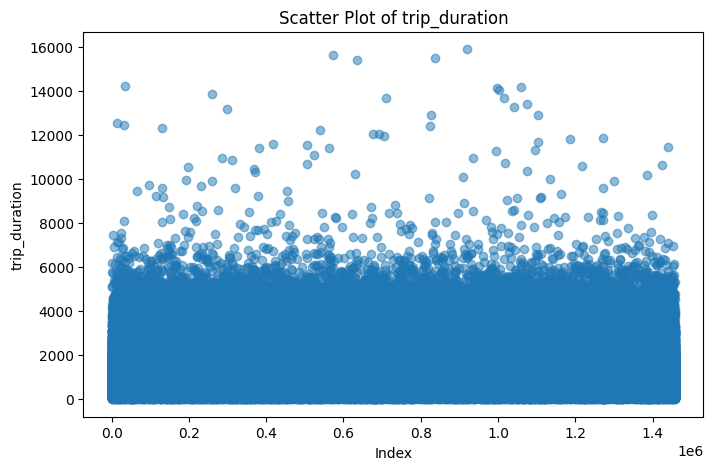

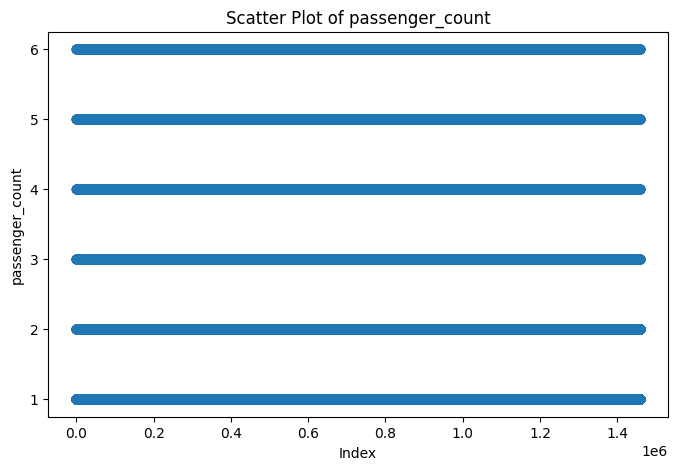

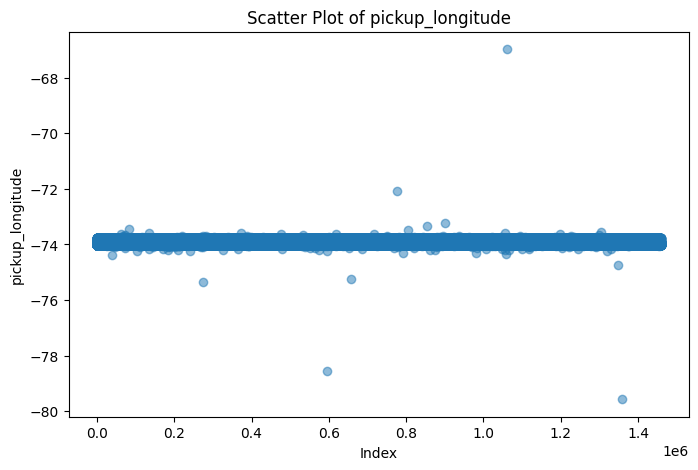

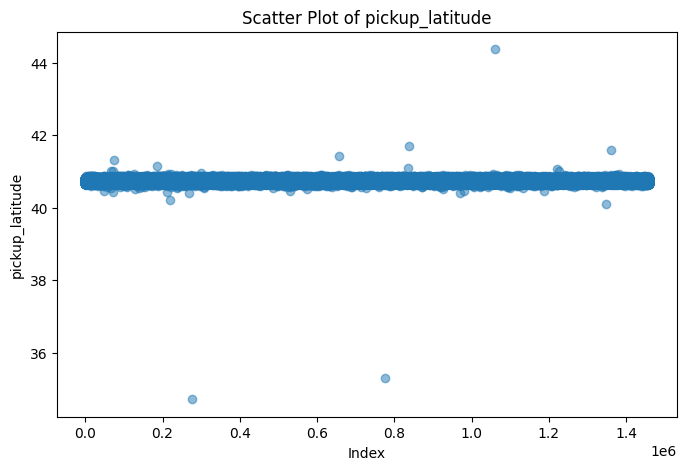

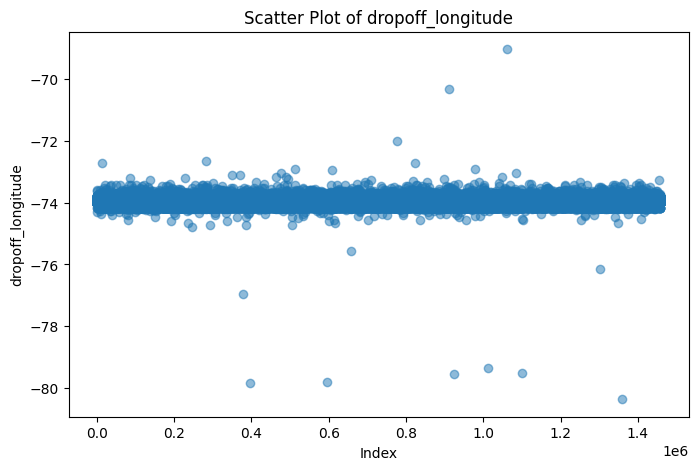

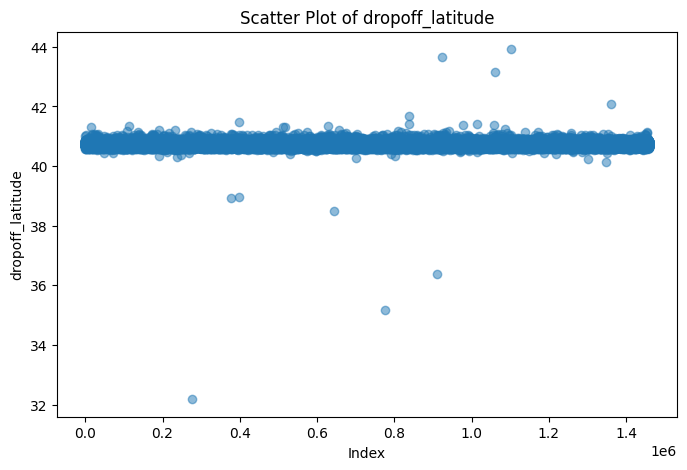

In [66]:
# Specify the columns you want to create scatter plots for
columns_to_plot = ['trip_duration', 'passenger_count', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude']

# Create scatter plots for the specified columns
for column in columns_to_plot:
    plt.figure(figsize=(8, 5))
    plt.scatter(train_c_no_outliers.index, train_c_no_outliers[column], alpha=0.5)
    plt.title(f'Scatter Plot of {column}')
    plt.xlabel('Index')
    plt.ylabel(column)
    plt.show()

## Violin Plot

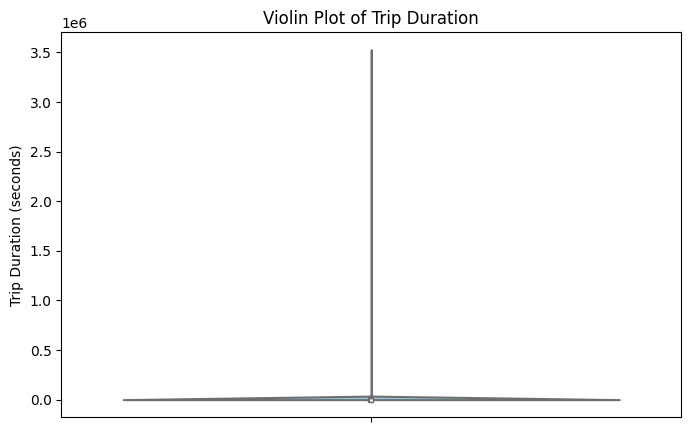

In [67]:
# Create a violin plot for trip duration
plt.figure(figsize=(8, 5))
sea.violinplot(data=train_df, y='trip_duration', color='skyblue')
plt.title('Violin Plot of Trip Duration')
plt.ylabel('Trip Duration (seconds)')
plt.show()

In [68]:
# # Create a violin plot for trip duration
# plt.figure(figsize=(8, 5))
# sea.violinplot(data=train_df_no_outliers, y='trip_duration', color='skyblue')
# plt.title('Violin Plot of Trip Duration')
# plt.ylabel('Trip Duration (seconds)')
# plt.show()

## checking the distribution in trip_duration column

<ipython-input-69-3263627c40f2>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sea.distplot(train_c_no_outliers['trip_duration'], kde=True, bins=30)


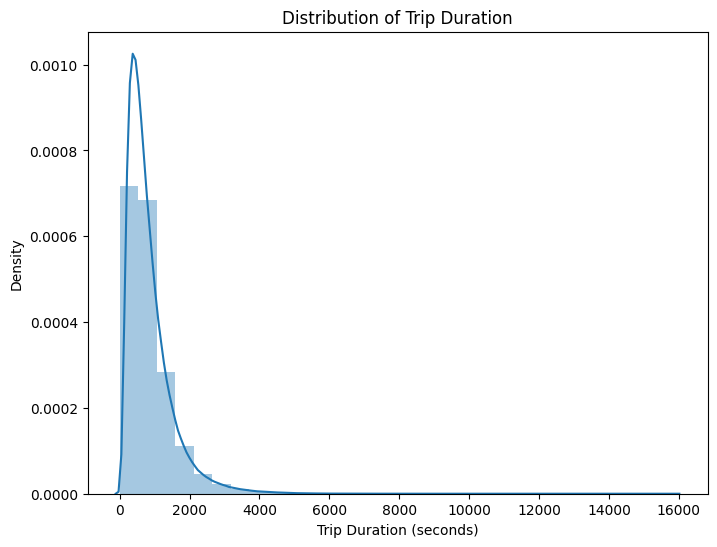

In [69]:
plt.figure(figsize=(8, 6))
sea.distplot(train_c_no_outliers['trip_duration'], kde=True, bins=30)
plt.title('Distribution of Trip Duration')
plt.xlabel('Trip Duration (seconds)')
plt.ylabel('Density')
plt.show()

<ipython-input-70-3263627c40f2>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sea.distplot(train_c_no_outliers['trip_duration'], kde=True, bins=30)


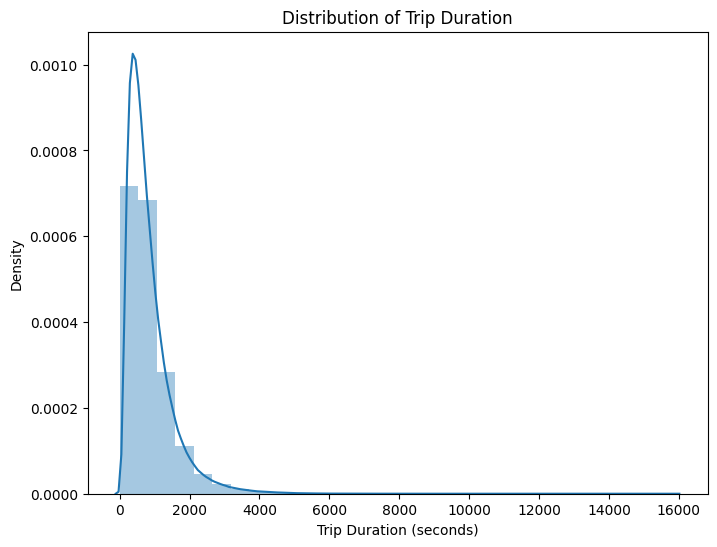

In [70]:
plt.figure(figsize=(8, 6))
sea.distplot(train_c_no_outliers['trip_duration'], kde=True, bins=30)
plt.title('Distribution of Trip Duration')
plt.xlabel('Trip Duration (seconds)')
plt.ylabel('Density')
plt.show()

Therefore converting  trip_duration to logrithmic values

<ipython-input-71-481c7562a1d7>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sea.distplot(np.log(train_c_no_outliers['trip_duration']), kde=True, bins=30)


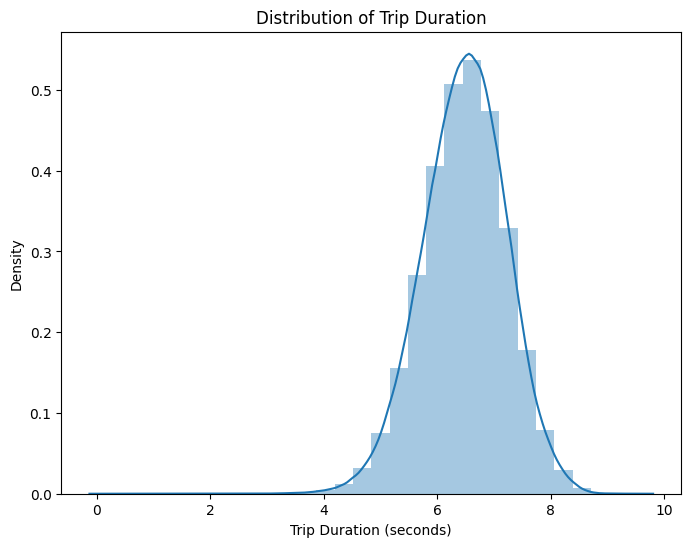

In [71]:
plt.figure(figsize=(8, 6))
sea.distplot(np.log(train_c_no_outliers['trip_duration']), kde=True, bins=30)
plt.title('Distribution of Trip Duration')
plt.xlabel('Trip Duration (seconds)')
plt.ylabel('Density')
plt.show()

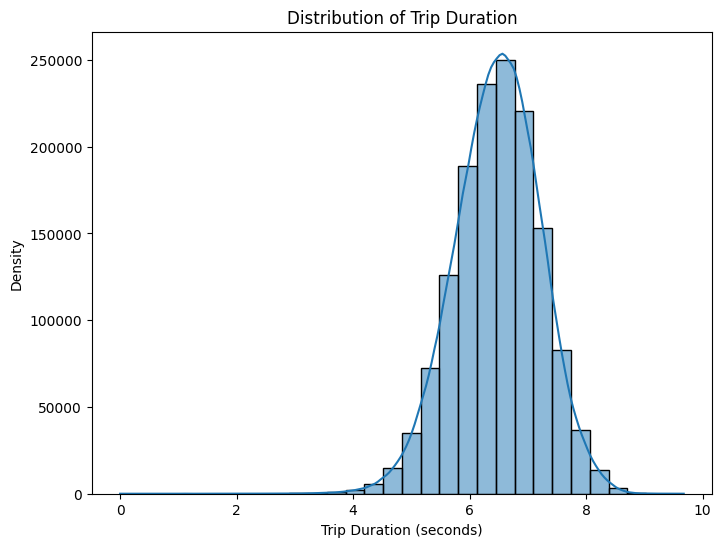

In [72]:
plt.figure(figsize=(8, 6))
sea.histplot(np.log(train_c_no_outliers['trip_duration']), kde=True, bins=30)
plt.title('Distribution of Trip Duration')
plt.xlabel('Trip Duration (seconds)')
plt.ylabel('Density')
plt.show()

In [73]:
train_c_no_outliers.head()

,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,pickup_date,pickup_hour,pickup_day,distance
0,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,455,2016-03-14,17,Monday,1.498521
1,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,663,2016-06-12,0,Sunday,1.805507
2,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,2124,2016-01-19,11,Tuesday,6.385098
3,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,429,2016-04-06,19,Wednesday,1.485498
4,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,435,2016-03-26,13,Saturday,1.188588


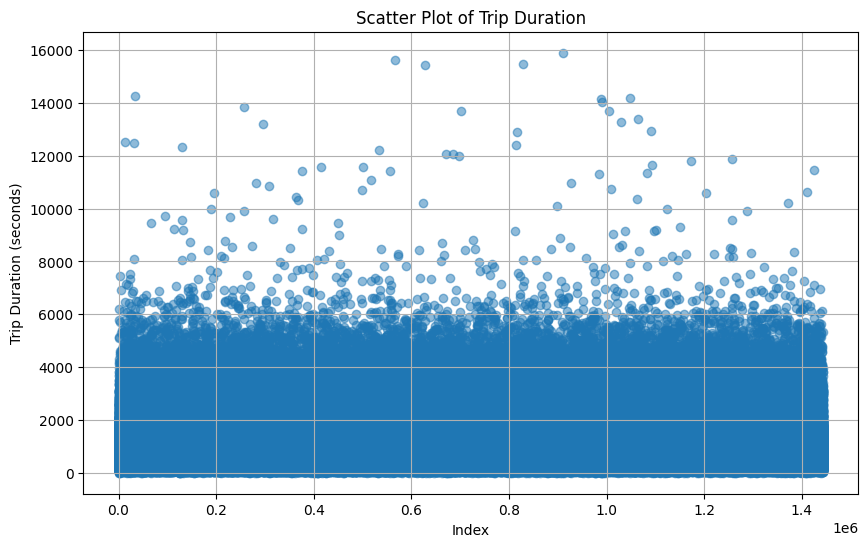

In [74]:
# Create a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(range(len(train_c_no_outliers['trip_duration'])), train_c_no_outliers['trip_duration'], alpha=0.5)

# Customize the plot with labels and title
plt.xlabel('Index')
plt.ylabel('Trip Duration (seconds)')
plt.title('Scatter Plot of Trip Duration')

# Show the plot
plt.grid(True)
plt.show()


In [75]:
max(train_c_no_outliers['trip_duration'])

15900

# Correlation Analysis

<ipython-input-76-ab6569f86674>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = train_c_no_outliers.corr()


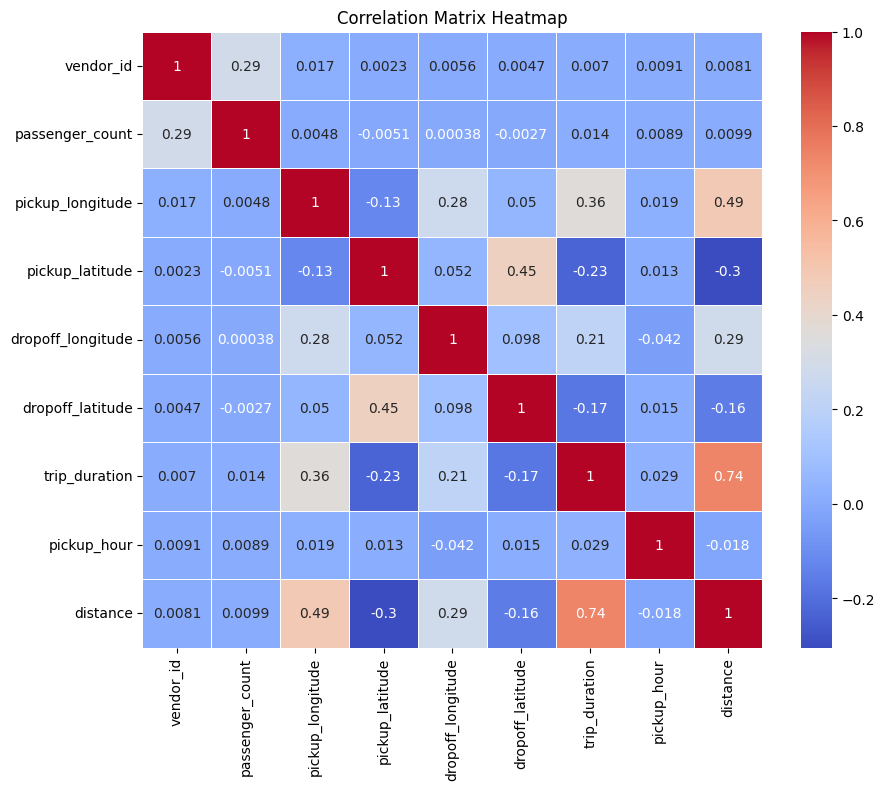

In [76]:
# Calculate the correlation matrix
correlation_matrix = train_c_no_outliers.corr()
# Create a heatmap of the correlation matrix
plt.figure(figsize=(10, 8))
sea.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix Heatmap')
plt.show()

In [77]:
train_c_no_outliers.head()

,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,pickup_date,pickup_hour,pickup_day,distance
0,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,455,2016-03-14,17,Monday,1.498521
1,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,663,2016-06-12,0,Sunday,1.805507
2,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,2124,2016-01-19,11,Tuesday,6.385098
3,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,429,2016-04-06,19,Wednesday,1.485498
4,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,435,2016-03-26,13,Saturday,1.188588


In [78]:
train_c_no_outliers['trip_duration'] = np.log(train_c_no_outliers['trip_duration'])

<ipython-input-78-399a24c29ece>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_c_no_outliers['trip_duration'] = np.log(train_c_no_outliers['trip_duration'])


# Checking Variance in each column

In [79]:
# Calculate the variance of each column in train_df_no_outliers
variance_per_column = train_c_no_outliers.var()
# Print the variance for each column
print("Variance of Each Column:")
print(variance_per_column)

Variance of Each Column:
vendor_id             0.248811
passenger_count       1.726990
pickup_longitude      0.001503
pickup_latitude       0.000833
dropoff_longitude     0.001453
dropoff_latitude      0.001151
trip_duration         0.545079
pickup_hour          40.926014
distance             16.871526
dtype: float64


<ipython-input-79-4c6f5e96a69f>:2: FutureWarning: The default value of numeric_only in DataFrame.var is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  variance_per_column = train_c_no_outliers.var()


# Feature Selection

In [80]:
train_df.shape

(1458644, 14)

In [81]:
train_c_no_outliers.shape

(1443256, 13)

In [82]:
train_c_no_outliers.columns

Index(['vendor_id', 'pickup_datetime', 'dropoff_datetime', 'passenger_count',
       'pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
       'dropoff_latitude', 'trip_duration', 'pickup_date', 'pickup_hour',
       'pickup_day', 'distance'],
      dtype='object')

In [83]:
train_c_no_outliers.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1443256 entries, 0 to 1458643
Data columns (total 13 columns):
 #   Column             Non-Null Count    Dtype         
---  ------             --------------    -----         
 0   vendor_id          1443256 non-null  int64         
 1   pickup_datetime    1443256 non-null  datetime64[ns]
 2   dropoff_datetime   1443256 non-null  object        
 3   passenger_count    1443256 non-null  int64         
 4   pickup_longitude   1443256 non-null  float64       
 5   pickup_latitude    1443256 non-null  float64       
 6   dropoff_longitude  1443256 non-null  float64       
 7   dropoff_latitude   1443256 non-null  float64       
 8   trip_duration      1443256 non-null  float64       
 9   pickup_date        1443256 non-null  object        
 10  pickup_hour        1443256 non-null  int64         
 11  pickup_day         1443256 non-null  object        
 12  distance           1443256 non-null  float64       
dtypes: datetime64[ns](1), float

In [84]:
train_c_no_outliers.head()

,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,pickup_date,pickup_hour,pickup_day,distance
0,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,6.120297,2016-03-14,17,Monday,1.498521
1,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,6.496775,2016-06-12,0,Sunday,1.805507
2,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,7.661056,2016-01-19,11,Tuesday,6.385098
3,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,6.061457,2016-04-06,19,Wednesday,1.485498
4,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,6.075346,2016-03-26,13,Saturday,1.188588


## Dropping off insignificant columns

In [85]:
columns_to_drop = [
     "pickup_datetime",
     "pickup_date",
    "dropoff_datetime",
     "passenger_count",
    'pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
    'dropoff_latitude'
]

# Drop the specified columns from the DataFrame
train_engineered = train_c_no_outliers.drop(columns=columns_to_drop)


In [86]:
train_engineered.head()

,vendor_id,trip_duration,pickup_hour,pickup_day,distance
0,2,6.120297,17,Monday,1.498521
1,1,6.496775,0,Sunday,1.805507
2,2,7.661056,11,Tuesday,6.385098
3,2,6.061457,19,Wednesday,1.485498
4,2,6.075346,13,Saturday,1.188588


In [87]:
train_engineered.shape

(1443256, 5)

In [88]:
# Define a mapping of days to numbers
day_to_number = {
    'Sunday': 1,
    'Monday': 2,
    'Tuesday': 3,
    'Wednesday': 4,
    'Thursday': 5,
    'Friday': 6,
    'Saturday': 7
}

# Map the 'pickup_day' column to numerical values
train_engineered['pickup_day'] = train_engineered['pickup_day'].map(day_to_number)


In [89]:
train_engineered.head()

,vendor_id,trip_duration,pickup_hour,pickup_day,distance
0,2,6.120297,17,2,1.498521
1,1,6.496775,0,1,1.805507
2,2,7.661056,11,3,6.385098
3,2,6.061457,19,4,1.485498
4,2,6.075346,13,7,1.188588


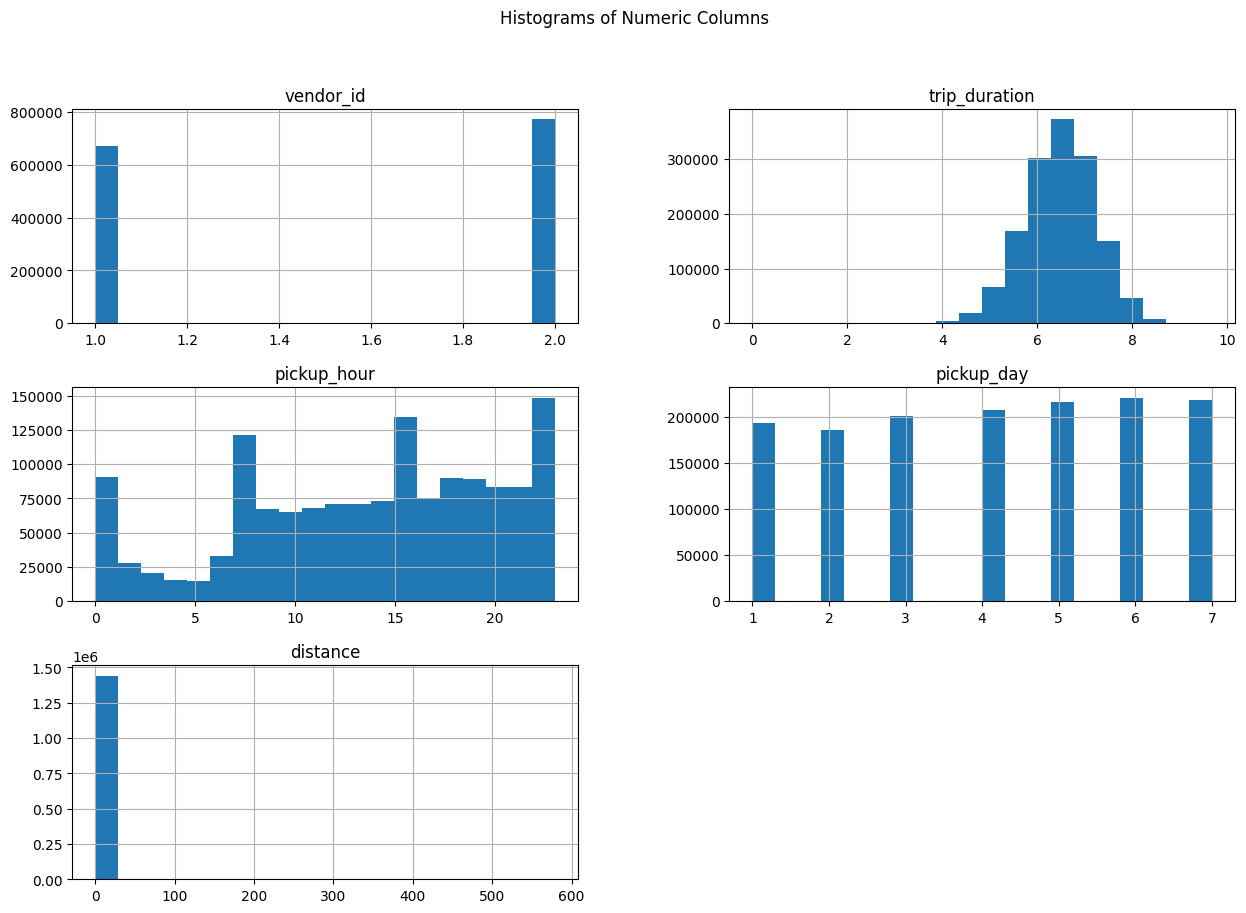

In [90]:
# Separate numeric and categorical columns
numeric_cols = train_engineered.select_dtypes(include=['number'])
categorical_cols = train_engineered.select_dtypes(exclude=['number'])

# Plot histograms for numeric columns
numeric_cols.hist(bins=20, figsize=(15, 10))
plt.suptitle("Histograms of Numeric Columns")
plt.show()

# Create bar plots for categorical columns
for column in categorical_cols.columns:
    plt.figure(figsize=(8, 5))
    categorical_cols[column].value_counts().plot(kind='bar')
    plt.title(f"Distribution of {column}")
    plt.xlabel(column)
    plt.ylabel("Count")
    plt.show()


In [91]:
train_engineered['distance'] = np.log(train_engineered['distance'])

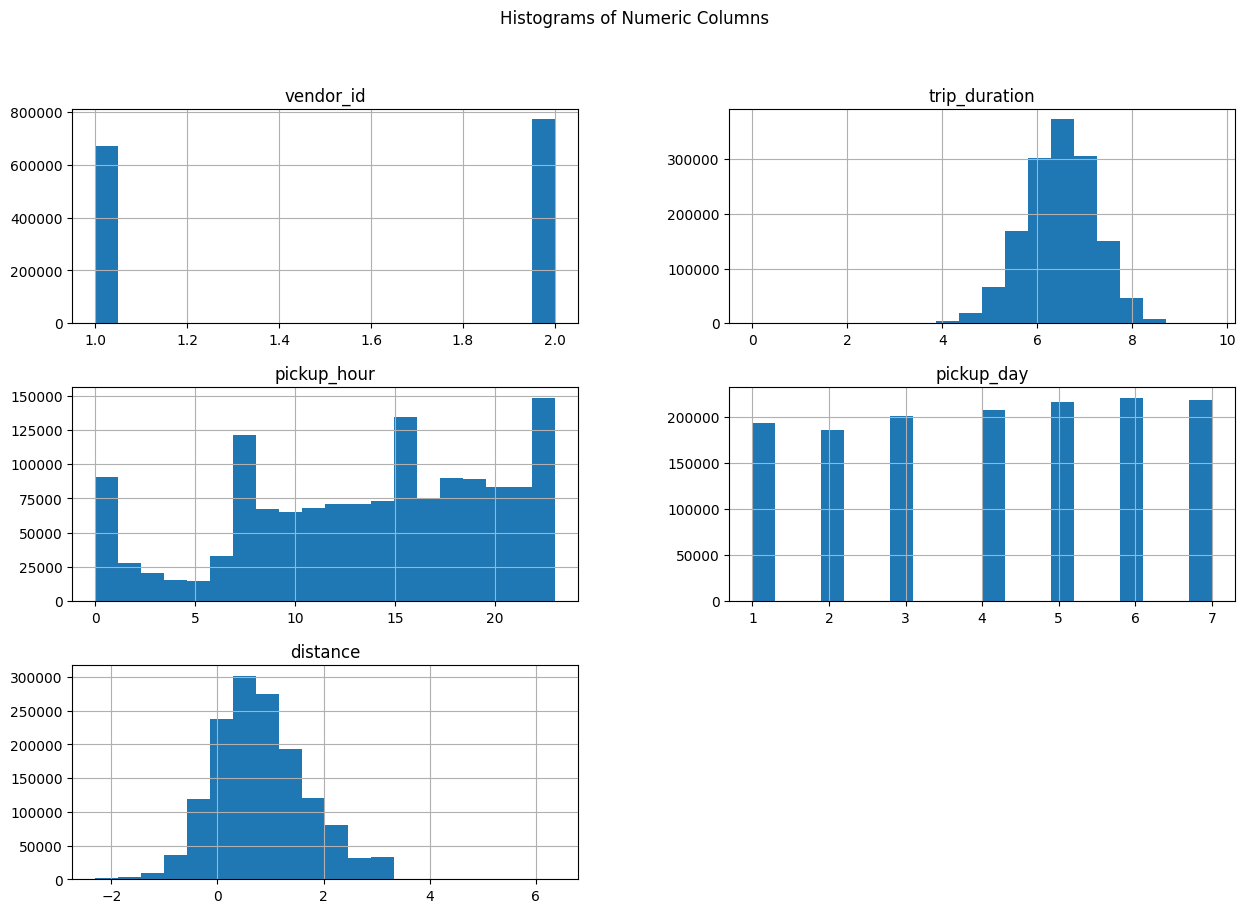

In [92]:
# Separate numeric and categorical columns
numeric_cols = train_engineered.select_dtypes(include=['number'])
categorical_cols = train_engineered.select_dtypes(exclude=['number'])

# Plot histograms for numeric columns
numeric_cols.hist(bins=20, figsize=(15, 10))
plt.suptitle("Histograms of Numeric Columns")
plt.show()

# Create bar plots for categorical columns
for column in categorical_cols.columns:
    plt.figure(figsize=(8, 5))
    categorical_cols[column].value_counts().plot(kind='bar')
    plt.title(f"Distribution of {column}")
    plt.xlabel(column)
    plt.ylabel("Count")
    plt.show()


In [93]:
# Initialize the Min-Max scaler
scaler = MinMaxScaler()

# Select the numeric columns to be scaled
numeric_cols = train_engineered.select_dtypes(include=['number'])

# Apply Min-Max scaling to the numeric columns
train_engineered[numeric_cols.columns] = scaler.fit_transform(numeric_cols)

In [95]:
train_engineered.head()

,vendor_id,trip_duration,pickup_hour,pickup_day,distance
0,1.0,0.632649,0.739130,0.166667,0.312457
1,0.0,0.671566,0.000000,0.000000,0.333968
2,1.0,0.791916,0.478261,0.333333,0.479766
3,1.0,0.626567,0.826087,0.500000,0.311450
4,1.0,0.628003,0.565217,1.000000,0.285711


In [96]:
# Define your features (independent variables)
X = train_engineered.drop(columns=["trip_duration"])

# Define your target variable (dependent variable)
y = train_engineered["trip_duration"]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Modelling

Linear Regression

In [97]:
#Linear Regression
# Initialize and train the linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared (R2) Score: {r2}")

Mean Squared Error: 0.0020959491839673324
R-squared (R2) Score: 0.6407131195910444


Mean Squared Error (MSE): The MSE measures the average squared difference between the actual and predicted values. In your case, the MSE of approximately 188,024 suggests that, on average, your model's predictions have a squared error of around 188,024 in terms of trip duration.

R-squared (R2) Score: The R2 score, also known as the coefficient of determination, measures the proportion of the variance in the dependent variable (trip duration) that is predictable from the independent variables (features). An R2 score of 0.0608 indicates that your model explains only about 6.08% of the variance in trip duration. In other words, your model has limited predictive power based on the chosen features.

The results suggest that the linear regression model may not be the best choice for predicting trip duration in your dataset, as the model's performance is relatively poor.

lIGHTgbm FROM kAGGLE

In [98]:
# Hyperparameter tuning with np.log(trip-duration)

# This cell takes 39 minutes for execution.

# Create an LGBMRegressor
model = LGBMRegressor()

# Define a grid of hyperparameters to search over
param_grid = {
    'n_estimators': [100, 500],
    'learning_rate': [0.01,  0.2],
    'num_leaves': [31, 127],
    'max_depth': [5, 10],
    'min_child_samples': [10, 30]
}

# Create a GridSearchCV object
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_squared_error')

# Fit the model with grid search
grid_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_

# Create a new model with the best hyperparameters
best_model = LGBMRegressor(**best_params)

# Train the model on the training data
best_model.fit(X_train, y_train)

# Make predictions on the test set
prediction = best_model.predict(X_test)

# Evaluate the model
rmse = mean_squared_error(y_test, prediction, squared=False)
r2 = r2_score(y_test, prediction)

print("Best Hyperparameters:", best_params)
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared (R2) Score: {r2}")


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.076462 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 288
[LightGBM] [Info] Number of data points in the train set: 923683, number of used features: 4
[LightGBM] [Info] Start training from score 0.669281
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[Light

Best Hyperparameters: {'learning_rate': 0.01, 'max_depth': 10, 'min_child_samples': 30, 'n_estimators': 500, 'num_leaves': 127}
Root Mean Squared Error (RMSE): 0.041419992681566264
R-squared (R2) Score: 0.7059097371116673

In [101]:
m = LGBMRegressor(learning_rate = 0.01, max_depth = 10, min_child_samples= 30 ,num_leaves = 127, n_estimators=500)
m.fit(X_train,y_train)

prediction = m.predict(X_test)
prediction

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015292 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 288
[LightGBM] [Info] Number of data points in the train set: 1154604, number of used features: 4
[LightGBM] [Info] Start training from score 0.669313


array([0.63146004, 0.66756252, 0.68587478, ..., 0.70336902, 0.59761954,
       0.54815802])

In [102]:
# Evaluate the model
rmse = mean_squared_error(y_test, prediction, squared=False)
r2 = r2_score(y_test, prediction)

print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared (R2) Score: {r2}")

Root Mean Squared Error (RMSE): 0.041419992681566264
R-squared (R2) Score: 0.7059097371116673


▶ A moderate R-squared, like 0.7, can be considered good, especially in complex real-world scenarios where it's challenging to explain all the variance in the target variable.

In [103]:
prediction = m.predict(X_test)
prediction

array([0.63146004, 0.66756252, 0.68587478, ..., 0.70336902, 0.59761954,
       0.54815802])

# Pre processing the test set

In [104]:
test_col

Index(['id', 'vendor_id', 'pickup_datetime', 'passenger_count',
       'pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
       'dropoff_latitude', 'store_and_fwd_flag'],
      dtype='object')

In [105]:
test_c.head()

,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,pickup_date,pickup_hour,pickup_day,distance
0,1,2016-06-30 23:59:58,1,-73.988129,40.732029,-73.990173,40.756680,2016-06-30,23,Thursday,2.746426
1,1,2016-06-30 23:59:53,1,-73.964203,40.679993,-73.959808,40.655403,2016-06-30,23,Thursday,2.759239
2,1,2016-06-30 23:59:47,1,-73.997437,40.737583,-73.986160,40.729523,2016-06-30,23,Thursday,1.306155
3,2,2016-06-30 23:59:41,1,-73.956070,40.771900,-73.986427,40.730469,2016-06-30,23,Thursday,5.269088
4,1,2016-06-30 23:59:33,1,-73.970215,40.761475,-73.961510,40.755890,2016-06-30,23,Thursday,0.960842


In [106]:
drop_test_cols = ["pickup_datetime", 'passenger_count', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
       'dropoff_latitude', "pickup_date"]


# Drop the specified columns from the DataFrame
test_engineered = test_c.drop(columns=drop_test_cols)

In [107]:
test_engineered.head()

,vendor_id,pickup_hour,pickup_day,distance
0,1,23,Thursday,2.746426
1,1,23,Thursday,2.759239
2,1,23,Thursday,1.306155
3,2,23,Thursday,5.269088
4,1,23,Thursday,0.960842


In [108]:
# Map the 'pickup_day' column to numerical values
test_engineered['pickup_day'] = test_engineered['pickup_day'].map(day_to_number)

In [109]:
test_engineered.head()

,vendor_id,pickup_hour,pickup_day,distance
0,1,23,5,2.746426
1,1,23,5,2.759239
2,1,23,5,1.306155
3,2,23,5,5.269088
4,1,23,5,0.960842


# Save the trained model to a file

In [110]:
model_filename = 'lgbm_model.pkl'
joblib.dump(m, model_filename)

['lgbm_model.pkl']

## Prediction on the given Test set

In [111]:
# Prediction on The given Test set
test_prediction = m.predict(test_engineered)
test_prediction

array([0.79932295, 0.79932295, 0.79932295, ..., 0.78979774, 0.78979774,
       0.78979774])

In [112]:
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score, mean_absolute_error

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test, prediction)
print(f"Mean Squared Error (MSE): {mse}")

# Calculate Root Mean Squared Error (RMSE)
rmse = mean_squared_error(y_test, prediction, squared=False)
print(f"Root Mean Squared Error (RMSE): {rmse}")

# Calculate R-squared (R2) Score
r2 = r2_score(y_test, prediction)
print(f"R-squared (R2) Score: {r2}")

# Calculate Explained Variance Score
explained_variance = explained_variance_score(y_test, prediction)
print(f"Explained Variance Score: {explained_variance}")

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, prediction)
print(f"Mean Absolute Error (MAE): {mae}")

Mean Squared Error (MSE): 0.0017156157937410028
Root Mean Squared Error (RMSE): 0.041419992681566264
R-squared (R2) Score: 0.7059097371116673
Explained Variance Score: 0.7059101017910691
Mean Absolute Error (MAE): 0.031212505648491987


# Real world Test

In [113]:
# Load the trained model
loaded_model = joblib.load('lgbm_model.pkl')

# Prepare a feature vector for prediction
# Example: Replace these values with your actual feature values
feature_vector = [[1.0, 0.739130, 0.166667, 0.312457]]

# Make predictions using the loaded model
predictions = loaded_model.predict(feature_vector)

print("Predicted Trip Duration:", predictions[0])


Predicted Trip Duration: 0.6429704512599339


In [114]:
# Load the saved model
loaded_model = joblib.load(model_filename)

# Define a new feature set for prediction
new_data = {
    'vendor_id': 1.0,
    'pickup_hour': 0.739130,
    'pickup_day': 0.166667,
    'distance': 0.312457
}

# Convert the new data to a DataFrame
new_data_df = pd.DataFrame([new_data])

# Make predictions on the new data using the loaded model
predictions = loaded_model.predict(new_data_df)

# Print the predicted trip duration
print(f"Predicted Trip Duration: {predictions[0]:.2f} seconds")


Predicted Trip Duration: 0.64 seconds


Best Hyperparameters:
{'learning_rate': 0.01,

'max_depth': 10,

'min_child_samples': 30,

'n_estimators': 500,

'num_leaves': 127}

Root Mean Squared Error (RMSE): 0.041419992681566264

R-squared (R2) Score: 0.7059097371116673

Achieved better model performance with the LightGBMRegressor:

- Root Mean Squared Error (RMSE): 0.0414
- R-squared (R2) Score: 0.7059

A lower RMSE and a higher R2 score indicate that the model is making more accurate predictions and explaining a significant portion of the variance in the data. These improved scores suggest that the LightGBM model is a good choice for regression task.

So this trained model can be used for making trip duration predictions.

⭕

#Mean Squared Error (MSE): The MSE value suggests that, on average, the squared difference between the predicted trip duration and the actual trip duration is relatively small. Lower MSE values indicate a better fit.

#Root Mean Squared Error (RMSE):  A lower RMSE is better.

# R-squared (R2) Score: A higher R2, indicates that model is capturing a significant portion of the variation in the data.

# Explained Variance Score: This score is very close to the R2 score, and they provide similar information about the explained variance. An explained variance score shows that model is effective in explaining the variability in the data.

# Mean Absolute Error (MAE): MAE measures the average absolute difference between the actual and predicted values. A lower MAE is better.